# Phase0 数据分析（重点：imageability 与 transparency）

本 notebook 基于 `data/output/phase0/phase0.json` 做快速分布分析，重点关注：
- `imageability`、`transparency` 的整体分布
- 两者关系（散点图）
- 两类 `*_details` 维度的平均画像（雷达图）

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 统一可视化风格，提升可读性
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.unicode_minus"] = False

# 自动定位项目根目录（包含 data/output/phase0/phase0.json 的目录）
PROJECT_ROOT = Path.cwd().resolve()
while not (PROJECT_ROOT / "data/output/phase0/phase0.json").exists() and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / "data/output/phase0/phase0.json"
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_PATH: {DATA_PATH}")

PROJECT_ROOT: D:\Opencode\T2IMVI
DATA_PATH: D:\Opencode\T2IMVI\data\output\phase0\phase0.json


In [2]:
with DATA_PATH.open("r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"记录数: {len(df)}")
print("列: ", list(df.columns))
df.head(3)

记录数: 615
列:  ['idiom_id', 'idiom', 'definition', 'imageability', 'transparency', 'imageability_details', 'transparency_details']


,idiom_id,idiom,definition,imageability,transparency,imageability_details,transparency_details
0,1,a little bird told me,['I received the information from a source not...,0.999621,0.664149,"{'concrete_nouns': 0.999999, 'physical_action'...","{'literal_hints_figurative': 0.0, 'everyday_wo..."
1,2,above board,"['Openly, without deceit', 'Honestly, reputably']",0.704737,0.635097,"{'concrete_nouns': 0.999999, 'physical_action'...","{'literal_hints_figurative': 1.7e-05, 'everyda..."
2,3,add fuel to the fire,"['To worsen a conflict between people', 'to in...",0.992998,0.872964,"{'concrete_nouns': 0.999999, 'physical_action'...","{'literal_hints_figurative': 1.0, 'everyday_wo..."


In [3]:
# 基础质量检查
missing_report = df[["imageability", "transparency"]].isna().sum().to_frame("missing_count")
missing_report["missing_ratio"] = missing_report["missing_count"] / len(df)

summary = df[["imageability", "transparency"]].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).T
summary

,count,mean,std,min,10%,25%,50%,75%,90%,max
imageability,615.0,0.775827,0.209792,0.214626,0.441598,0.659050,0.844037,0.928702,0.999442,1.000000
transparency,615.0,0.687831,0.148536,0.244978,0.481974,0.585673,0.694423,0.797468,0.873675,0.998958


In [4]:
missing_report

,missing_count,missing_ratio
imageability,0,0.0
transparency,0,0.0


## 1) 重点指标分布
同时展示直方图 + KDE 曲线，便于观察集中趋势与尾部。

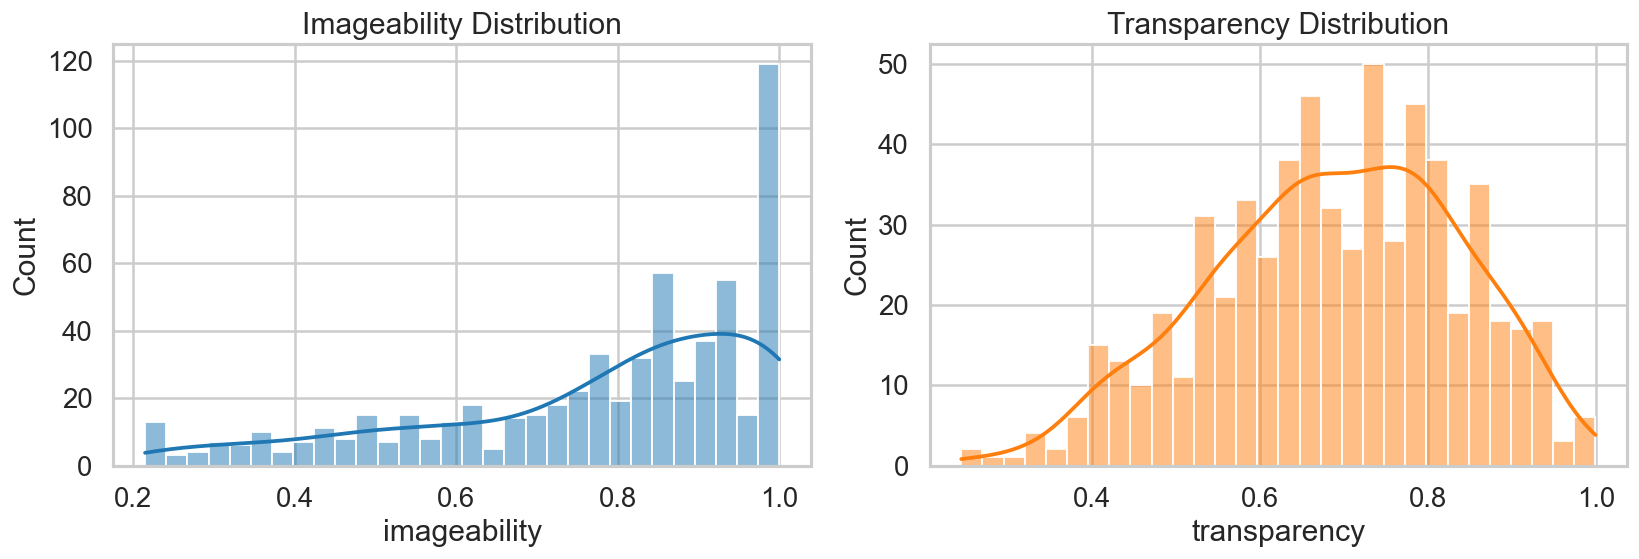

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["imageability"], bins=30, kde=True, color="#1f77b4", ax=axes[0])
axes[0].set_title("Imageability Distribution")
axes[0].set_xlabel("imageability")

sns.histplot(df["transparency"], bins=30, kde=True, color="#ff7f0e", ax=axes[1])
axes[1].set_title("Transparency Distribution")
axes[1].set_xlabel("transparency")

plt.tight_layout()
plt.show()

C:\Users\LIU423\AppData\Local\Temp\ipykernel_25456\3370552841.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=long_df, x="metric", y="score", palette=["#1f77b4", "#ff7f0e"])


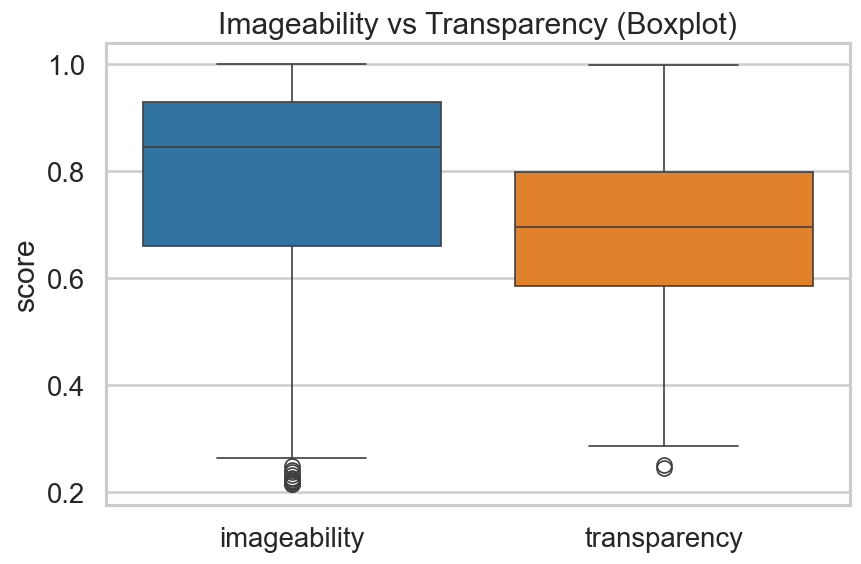

In [6]:
# 箱线图对比，快速观察离群点与分布宽度
long_df = df[["imageability", "transparency"]].melt(var_name="metric", value_name="score")

plt.figure(figsize=(8, 5))
sns.boxplot(data=long_df, x="metric", y="score", palette=["#1f77b4", "#ff7f0e"])
plt.title("Imageability vs Transparency (Boxplot)")
plt.xlabel("")
plt.ylabel("score")
plt.show()

## 2) 关系分析（散点图）
散点图是重点图：展示 `imageability` 与 `transparency` 的关系，并加回归趋势线。

Pearson correlation = 0.3406


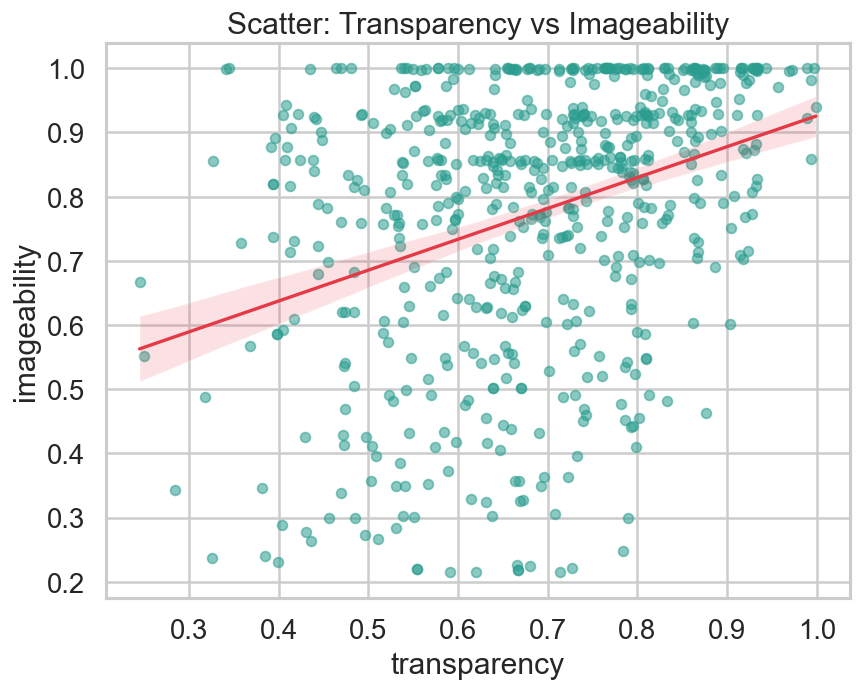

In [13]:
corr = df[["imageability", "transparency"]].corr().iloc[0, 1]
print(f"Pearson correlation = {corr:.4f}")

plt.figure(figsize=(8, 6))
sns.regplot(
    data=df,
    x="transparency",
    y="imageability",
    scatter_kws={"alpha": 0.55, "s": 35, "color": "#2a9d8f"},
    line_kws={"color": "#e63946", "lw": 2}
)
plt.title("Scatter: Transparency vs Imageability")
plt.xlabel("transparency")
plt.ylabel("imageability")
plt.show()

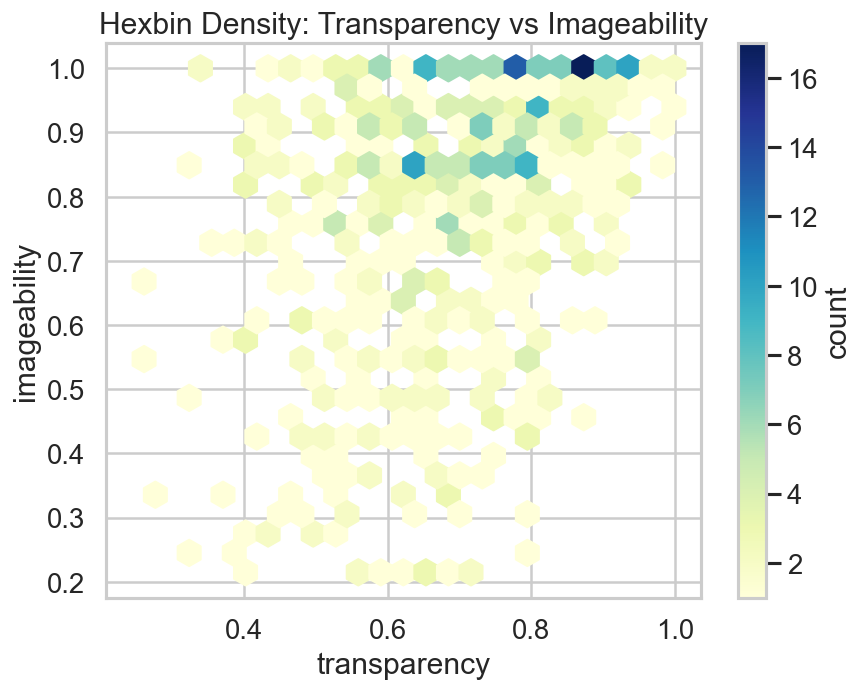

In [14]:
# 密度版关系图，点数较多时更清晰
plt.figure(figsize=(8, 6))
plt.hexbin(df["transparency"], df["imageability"], gridsize=24, cmap="YlGnBu", mincnt=1)
plt.colorbar(label="count")
plt.title("Hexbin Density: Transparency vs Imageability")
plt.xlabel("transparency")
plt.ylabel("imageability")
plt.show()

quadrant_label
Q1 (Img>=0.5, Trans>=0.5)    475
Q2 (Img<0.5, Trans>=0.5)      66
Q3 (Img<0.5, Trans<0.5)       18
Q4 (Img>=0.5, Trans<0.5)      56
Name: idiom_count, dtype: int64


C:\Users\LIU423\AppData\Local\Temp\ipykernel_25456\1502340529.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


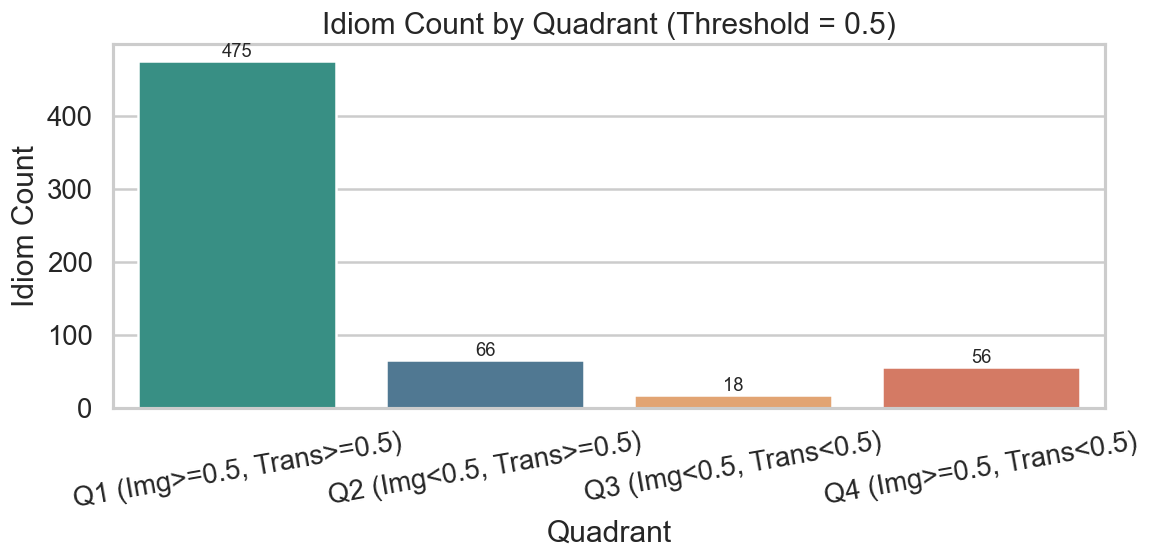

In [15]:
# ? (0.5, 0.5) ????????????????? idiom ?
quad_df = df.copy()
quad_df["img_bin"] = np.where(quad_df["imageability"] >= 0.5, "H", "L")
quad_df["trans_bin"] = np.where(quad_df["transparency"] >= 0.5, "H", "L")

quad_df["quadrant"] = quad_df["img_bin"] + "-" + quad_df["trans_bin"]
quad_label_map = {
    "H-H": "Q1 (Img>=0.5, Trans>=0.5)",
    "L-H": "Q2 (Img<0.5, Trans>=0.5)",
    "L-L": "Q3 (Img<0.5, Trans<0.5)",
    "H-L": "Q4 (Img>=0.5, Trans<0.5)",
}
quad_df["quadrant_label"] = quad_df["quadrant"].map(quad_label_map)

order = [
    "Q1 (Img>=0.5, Trans>=0.5)",
    "Q2 (Img<0.5, Trans>=0.5)",
    "Q3 (Img<0.5, Trans<0.5)",
    "Q4 (Img>=0.5, Trans<0.5)",
]

quad_count = (
    quad_df.groupby("quadrant_label")["idiom"]
    .count()
    .reindex(order, fill_value=0)
    .rename("idiom_count")
)

print(quad_count)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x=quad_count.index,
    y=quad_count.values,
    palette=["#2a9d8f", "#457b9d", "#f4a261", "#e76f51"],
)
ax.set_title("Idiom Count by Quadrant (Threshold = 0.5)")
ax.set_xlabel("Quadrant")
ax.set_ylabel("Idiom Count")
plt.xticks(rotation=10)

for i, v in enumerate(quad_count.values):
    ax.text(i, v, str(int(v)), ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

## 2.5)  60 idioms

In [16]:
#  idiom_id

def add_quadrant_labels(df, img_col="imageability", trans_col="transparency", threshold=0.5):
    out = df.copy()
    out["img_bin"] = np.where(out[img_col] >= threshold, "H", "L")
    out["trans_bin"] = np.where(out[trans_col] >= threshold, "H", "L")
    out["quadrant"] = out["img_bin"] + "-" + out["trans_bin"]
    return out


def allocate_by_proportion(counts, n_total):
    # Allocate counts proportionally to n_total
    prop = counts / counts.sum()
    raw = prop * n_total
    base = np.floor(raw).astype(int)
    remainder = raw - base

    short = int(n_total - base.sum())
    if short > 0:
        order = remainder.sort_values(ascending=False).index[:short]
        base.loc[order] += 1

    return base


def stratified_sample_quadrants(df, n_total=60, threshold=0.5, seed=42, id_col="idiom_id"):
    np.random.seed(seed)
    qdf = add_quadrant_labels(df, threshold=threshold)

    counts = qdf["quadrant"].value_counts().sort_index()
    allocation = allocate_by_proportion(counts, n_total)

    sampled_parts = []
    for quad, n in allocation.items():
        part = qdf[qdf["quadrant"] == quad].sample(n=int(n), random_state=seed)
        sampled_parts.append(part)

    sampled = (
        pd.concat(sampled_parts, ignore_index=True)
        .sample(frac=1, random_state=seed)
        .reset_index(drop=True)
    )

    alloc_table = pd.DataFrame({
        "quadrant_count": counts,
        "sample_n": allocation,
        "sample_ratio": allocation / n_total,
    })

    sampled_ids = sampled[id_col].tolist()
    return sampled, sampled_ids, alloc_table


sampled_idioms_df, sampled_id_list, sample_alloc_table = stratified_sample_quadrants(
    df,
    n_total=60,
    threshold=0.5,
    seed=42,
    id_col="idiom_id",
)

print("Sample Allocation Table:")
display(sample_alloc_table)

print(f"Number of sampled idioms: {len(sampled_id_list)}")

# 按象限展示 idiom_id（完整显示）
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

ids_by_quadrant = (
    sampled_idioms_df.groupby("quadrant")["idiom_id"]
    .apply(list)
    .sort_index()
)
print("Sampled idiom_id by quadrant:")
display(ids_by_quadrant.to_frame("idiom_ids"))

# Display sampled idioms with relevant columns
# display(sampled_idioms_df[["idiom_id", "idiom", "quadrant", "imageability", "transparency"]].head(20))

Sample Allocation Table:


,quadrant_count,sample_n,sample_ratio
quadrant,,,
H-H,475,46,0.766667
H-L,56,6,0.100000
L-H,66,6,0.100000
L-L,18,2,0.033333


Number of sampled idioms: 60
Sampled idiom_id by quadrant:


,idiom_ids
quadrant,
H-H,"[489, 47, 553, 535, 324, 105, 163, 611, 96, 137, 152, 104, 178, 464, 77, 566, 223, 43, 380, 85, 121, 605, 570, 619, 485, 344, 563, 202, 371, 160, 318, 555, 1, 15, 54, 31, 18, 102, 322, 391, 109, 583, 92, 420, 133, 541]"
H-L,"[393, 13, 211, 60, 135, 559]"
L-H,"[6, 610, 545, 73, 415, 609]"
L-L,"[14, 21]"


## 3) 细分维度画像（雷达图）
分别对 `imageability_details`、`transparency_details` 做维度均值可视化。

In [9]:
img_details = pd.DataFrame(df["imageability_details"].tolist())
trp_details = pd.DataFrame(df["transparency_details"].tolist())

img_mean = img_details.mean().sort_values(ascending=False)
trp_mean = trp_details.mean().sort_values(ascending=False)

print("Imageability details (mean, top 8):")
display(img_mean.head(8).to_frame("mean"))
print("Transparency details (mean, top 8):")
display(trp_mean.head(8).to_frame("mean"))

Imageability details (mean, top 8):


,mean
concrete_nouns,0.999999
real_world,0.999990
short_phrase,0.989323
concrete_words,0.924183
single_scene,0.909569
temporal_simplicity,0.841317
spatial_layout,0.776303
culture_neutral,0.743667


Transparency details (mean, top 8):


,mean
no_hidden_metaphors,0.999971
common_vocabulary,0.997625
paraphrase_from_parts,0.964417
synonym_robust,0.954040
imageable_literal,0.922657
morphological_flexibility,0.906601
low_cultural_dependence,0.893003
everyday_word_sense,0.818267


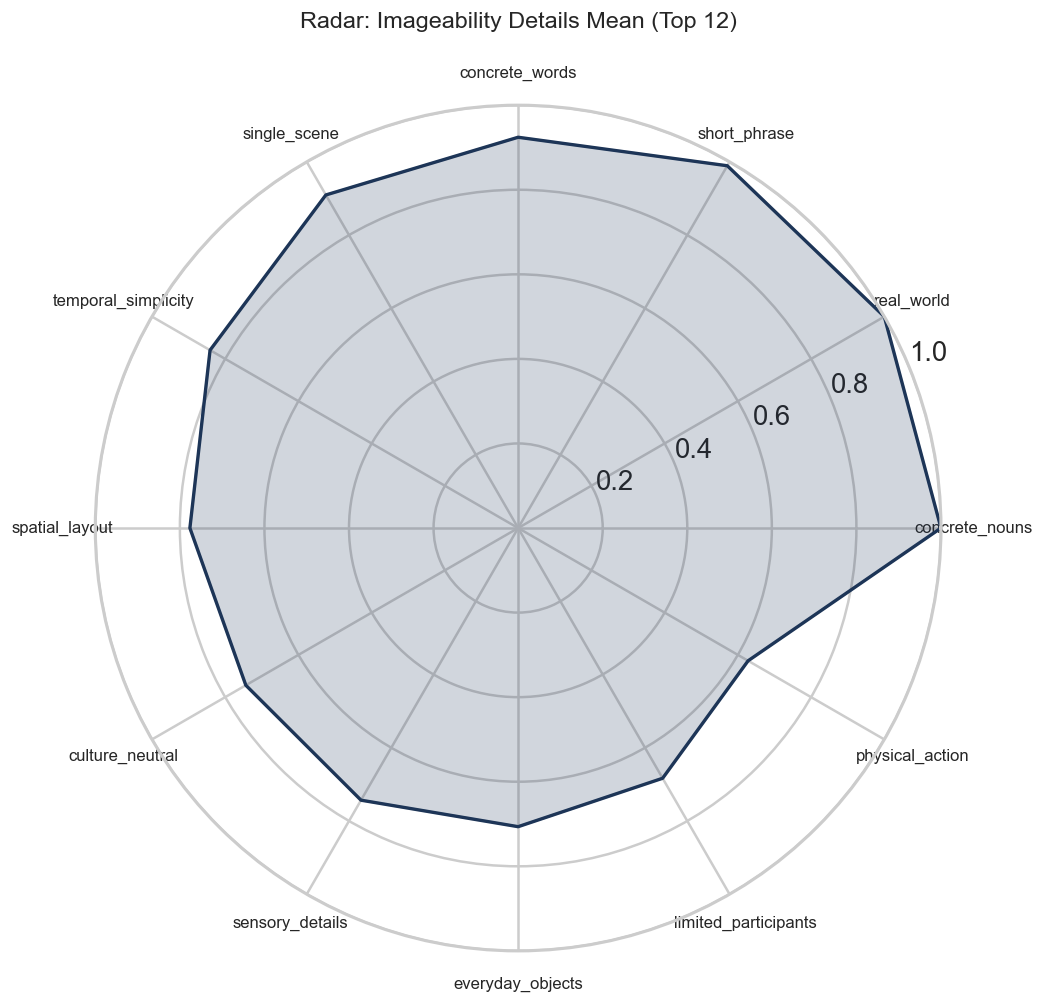

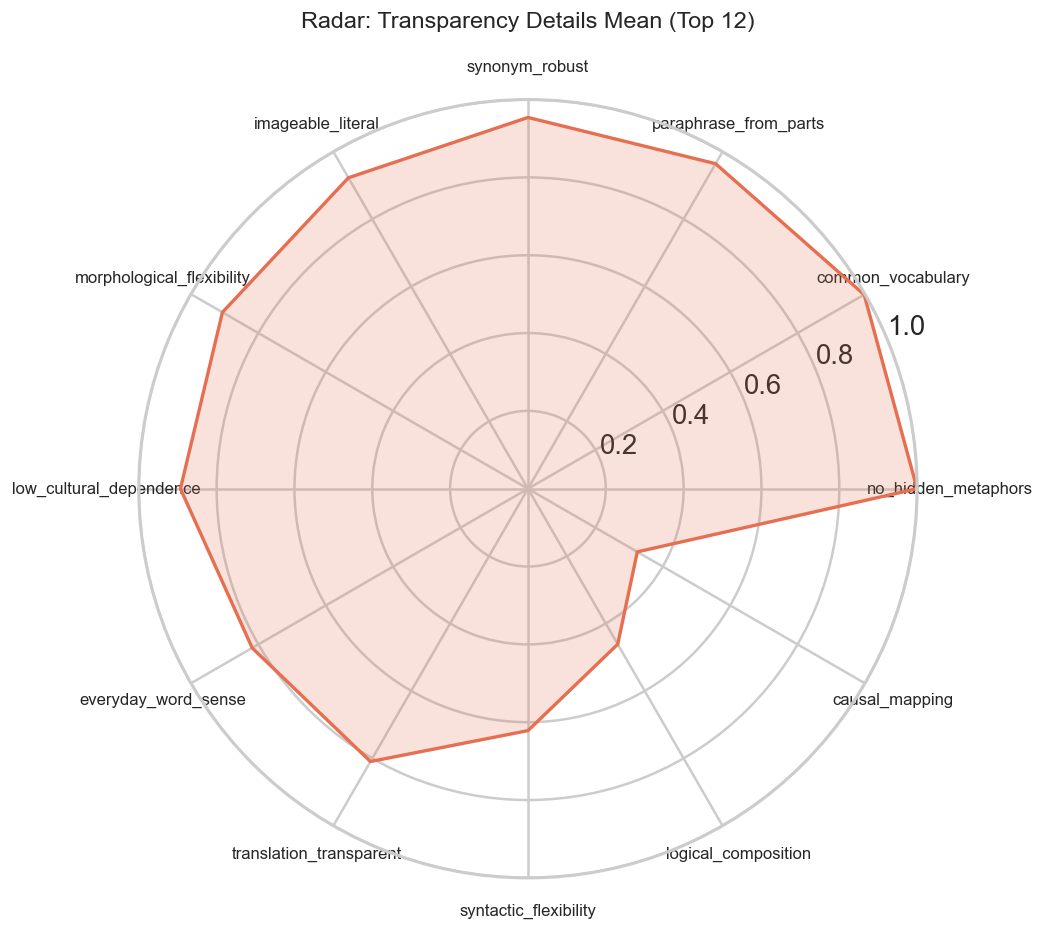

In [10]:
def radar_plot(series, title, color="#264653"):
    labels = series.index.tolist()
    values = series.values.tolist()

    # 闭合雷达图
    labels = labels + [labels[0]]
    values = values + [values[0]]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=True)

    fig = plt.figure(figsize=(9, 9))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values, color=color, linewidth=2)
    ax.fill(angles, values, color=color, alpha=0.2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels[:-1], fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(title, y=1.08, fontsize=14)
    plt.tight_layout()
    plt.show()

# 维度多时按均值前12维展示，兼顾信息量和可读性
radar_plot(img_mean.head(12), "Radar: Imageability Details Mean (Top 12)", color="#1d3557")
radar_plot(trp_mean.head(12), "Radar: Transparency Details Mean (Top 12)", color="#e76f51")

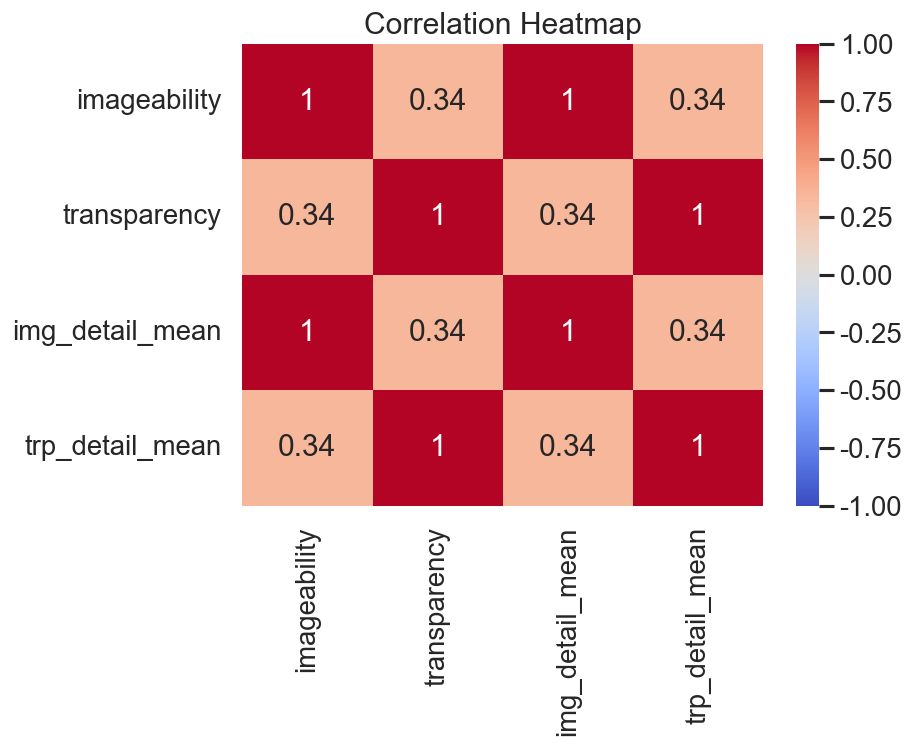

In [11]:
# 相关热力图（总分 + 子维度均值）
meta = pd.DataFrame({
    "imageability": df["imageability"],
    "transparency": df["transparency"],
    "img_detail_mean": img_details.mean(axis=1),
    "trp_detail_mean": trp_details.mean(axis=1),
})

plt.figure(figsize=(7, 5))
sns.heatmap(meta.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

## 4) 简要结论模板（可按图更新）
- `imageability` 整体分布：主要集中在较高区间（可结合直方图与箱线图确认）。
- `transparency` 整体分布：相较 `imageability` 略低，但仍有明显集中区间。
- 两者关系：通过散点图/回归线查看是否正相关（以相关系数与图形为准）。
- 细分维度：雷达图可以快速定位高均值维度和相对薄弱维度。